In [1]:
import time
import json
import datetime as dt
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import numpy as np
import pwlf

In [2]:
# Selecting the game
game_name = 'elden_ring'

In [3]:
# Getting the game ID
base_url = 'https://www.speedrun.com/api/v1'

response = requests.get(f'{base_url}/games?name={game_name}')
data = response.json()

In [4]:
# Define the status, platform, order, direction, and max results
status = 'verified'
platform = '8gej2n93'  # Platform == PC
orderby = 'date'
direction = 'asc'
max_results = 200  # Maximum results per page

In [5]:
def get_game_id(game_name):
    response = requests.get(f'{base_url}/games?name={game_name}')
    data = response.json()
    if response.status_code == 200:
        return data['data'][0]['id']
    else:
        return None

get_game_id(game_name)

'nd28z0ed'

In [6]:
# Define a function to get the categories for a game
def get_categories(game_id):
    response = requests.get(f'{base_url}/games/{game_id}/categories')
    if response.status_code == 200:
        data = response.json()
        categories = {}
        for category in data['data']:
            categories[category['id']] = category['name']
        return categories
    else:
        print(f'Request failed with status code {response.status_code}.')
        return None

In [7]:
# Define a function to get the runs for a category
def get_runs_for_category(game_id, category_id, category_name):
    extracted_data = []
    page = 0
    while True:
        offset = page * max_results
        response = requests.get(f'{base_url}/runs?game={game_id}&category={category_id}&status={status}&platform={platform}&orderby={orderby}&direction={direction}&max={max_results}&offset={offset}')
        if response.status_code == 200:
            data = response.json()
            if not data['data']:
                break
            for run in data['data']:
                date = run['date']
                submitted = run['submitted']
                verified = run['status']['status']
                primary_t = run['times']['primary_t']
                realtime_t = run['times']['realtime_t']
                extracted_data.append([date, submitted, verified, primary_t, realtime_t, category_name])
            print(f'Page {page + 1} processed for category {category_name}.')
        else:
            print(f'Request failed with status code {response.status_code}. Stopping data collection.')
            print(response.text)
            break
        time.sleep(.6)
        page += 1
    return extracted_data

In [8]:
# Get the game ID
game_id = get_game_id(game_name)

# Get the categories for the game
categories = get_categories(game_id)

# Initialize an empty list to store all the data
all_data = []

# Get the runs for each category
for category_id, category_name in categories.items():
    all_data.extend(get_runs_for_category(game_id, category_id, category_name))

# Convert the list to a DataFrame
df = pd.DataFrame(all_data, columns=['Date', 'Submitted', 'Verified', 'Primary_t', 'Realtime_t', 'Category'])

# Save the DataFrame to a CSV file
df.to_csv('speedrun_data.csv', index=False)

Page 1 processed for category Any%.
Page 2 processed for category Any%.
Page 1 processed for category Any% Unrestricted.
Page 1 processed for category Any% No Wrong Warp.
Page 1 processed for category Any% Glitchless.
Page 2 processed for category Any% Glitchless.
Page 1 processed for category All Remembrances.
Page 1 processed for category All Remembrances Glitchless.
Page 1 processed for category All Achievements.


In [9]:
# Load the data from the CSV file into a new df
csv_df = pd.read_csv('speedrun_data.csv')
csv_df

,Date,Submitted,Verified,Primary_t,Realtime_t,Category
0,2022-03-17,2022-03-26T17:05:58Z,verified,2079,2079,Any%
1,2022-03-18,2022-03-27T22:39:38Z,verified,1715,1715,Any%
2,2022-03-20,2022-03-25T06:09:10Z,verified,1644,1644,Any%
3,2022-03-22,2022-03-25T02:25:10Z,verified,2402,2402,Any%
4,2022-03-22,2022-03-26T14:50:15Z,verified,1798,1798,Any%
...,...,...,...,...,...,...
885,2022-12-18,2022-12-18T18:35:19Z,verified,9941,9941,All Achievements
886,2023-02-20,2023-02-20T02:27:55Z,verified,10186,10186,All Achievements
887,2023-02-25,2023-02-24T21:45:35Z,verified,9770,9770,All Achievements
888,2023-03-16,2023-03-16T21:48:54Z,verified,9636,9636,All Achievements


In [10]:
# Filter out rows where 'Date' or 'Submitted' is None
csv_df = csv_df[csv_df['Date'].notnull() & csv_df['Submitted'].notnull()]

# Filter out Realtime that is 0
csv_df = csv_df[csv_df['Realtime_t'] > 0]
csv_df.count()

Date          890
Submitted     890
Verified      890
Primary_t     890
Realtime_t    890
Category      890
dtype: int64

In [11]:
csv_df['Category'].value_counts()

Category
Any%                           267
Any% Glitchless                247
All Remembrances               179
Any% No Wrong Warp              86
All Remembrances Glitchless     57
Any% Unrestricted               34
All Achievements                20
Name: count, dtype: int64

In [12]:
# Get the category with the most runs
top_category = csv_df['Category'].value_counts().idxmax()

# Filter the DataFrame to only include runs from the top category
csv_df = csv_df[csv_df['Category'] == top_category]
top_category

'Any%'

### Preparing data to do linear fit

In [13]:
# Getting the running top score
csv_df['Top_Score'] = csv_df['Realtime_t'].cummin()

# Converting 'Date' is in datetime format
csv_df['Date'] = pd.to_datetime(csv_df['Date'])

# Sort by date
csv_df = csv_df.sort_values('Date')

# Define x (date) and y (top score)
x = csv_df['Date'].map(dt.datetime.toordinal).values
y = csv_df['Top_Score'].values

# Initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(x, y)

# Fit the data for two line segments
res = my_pwlf.fit(2)

# Predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

# Convert the ordinal dates back to datetime for plotting
x_dates = [dt.datetime.fromordinal(int(i)) for i in xHat]

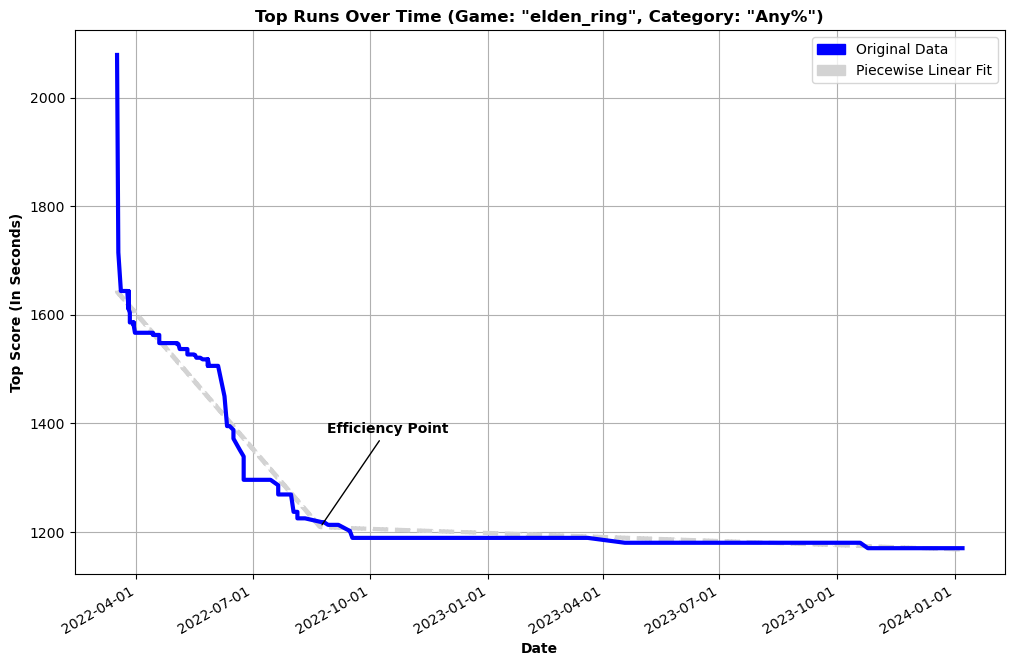

In [14]:
# Create a new figure and axes with a larger size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the piecewise linear fit
ax.plot(x_dates, yHat, linestyle='--', linewidth=3, color='lightgrey', label='Piecewise Linear Fit')

# Plot the original data
ax.plot(csv_df['Date'], csv_df['Top_Score'], linestyle='solid', linewidth=3, color='blue', label='Original Data')

# Get the breakpoints that were calculated during the fit
breakpoints = my_pwlf.fit_breaks

# The elbow is the second breakpoint (the first one is the start of the data)
elbow_x = breakpoints[1]
elbow_y = my_pwlf.predict(elbow_x)

# Convert the ordinal date back to a datetime
elbow_date = dt.datetime.fromordinal(int(elbow_x))

# Define the end point of the line (getting the label closer to the middle of the graph)
end_x = elbow_date + (max(csv_df['Date']) - elbow_date) / 100
end_y = elbow_y + (max(csv_df['Top_Score']) - elbow_y) / 5

# Add the annotation for the elbow with a line going to the middle of the graph
ax.annotate('Efficiency Point', fontweight='bold',
            xy=(elbow_date, elbow_y),
            xytext=(end_x, end_y),
            arrowprops=dict(arrowstyle='-', color='black'))

# Set the title and labels
ax.set_title(f'Top Runs Over Time (Game: "{game_name}", Category: "{top_category}")', fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Top Score (In Seconds)', fontweight='bold')

# Format date
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Rotate date labels automatically
fig.autofmt_xdate()

# Create custom legend handles
handle1 = mpatches.Patch(color='blue', label='Original Data')
handle2 = mpatches.Patch(color='lightgrey', label='Piecewise Linear Fit')

# Add the custom legend
ax.legend(handles=[handle1, handle2], loc='upper right')

# Add grid lines
ax.grid(True)

# Show the plot
plt.show()

In [15]:
# Get the index of the elbow in the original data
elbow_index = np.abs(x - elbow_x).argmin()

# Calculate the number of runs to the efficiency point
runs_to_efficiency = elbow_index + 1  # add 1 because indexing starts at 0

# Calculate the percentage of runs complete at efficiency
pct_runs_complete_at_efficiency = (runs_to_efficiency / len(x)) * 100

# Calculate the number of days to the efficiency point
days_to_efficiency = (elbow_date - min(csv_df['Date'])).days

# Calculate the total number of days in the data
total_days = (max(csv_df['Date']) - min(csv_df['Date'])).days

# Calculate the percentage of days to efficiency out of total days
pct_days_to_efficiency = (days_to_efficiency / total_days) * 100

# Print the information
print(f"Number of runs to efficiency point: {runs_to_efficiency}")
print(f"Total runs: {len(x)}")
print(f"Date of efficiency: {elbow_date.strftime('%Y-%m-%d')}")
print(f"Score at efficiency: {elbow_y}")
print(f"Percentage of runs complete at efficiency: {pct_runs_complete_at_efficiency:.2f}%")

# Print the information
print("")
print(f"Number of days to the efficiency point: {days_to_efficiency}")
print(f"Total number of days: {total_days}")
print(f"Percentage of days to efficiency: {pct_days_to_efficiency:.2f}%")

Number of runs to efficiency point: 232
Total runs: 267
Date of efficiency: 2022-08-23
Score at efficiency: [1208.87492085]
Percentage of runs complete at efficiency: 86.89%

Number of days to the efficiency point: 159
Total number of days: 661
Percentage of days to efficiency: 24.05%
